# Evaluación de la segmentación 

| **Asignatura**           | **Integrantes:**               | **Fecha**|
|--------------------------|--------------------------------|----------|
| Percepción Computacional | Avila Ramírez Larissa Samantha |  28/05/25|
|                          | Hernández Terán Román          |          |

# Ground Truth


Es la referencia objetiva y verificada con la que se comparan las predicciones de un sistema para saber qué tan bien está funcionando.

Para validar la segmentación, tiene que haber una segmentación de referencia, lo que se denomina generalmente como un **ground truth**. Este ground truth se tiene que obtener de forma manual, pintando la silueta de los objetos de interés con un color uniforme.

A menudo, la obtención de estos ground truths se denomina _etiquetado manual de imágenes_ o, en este caso, _segmentación manual de imágenes_

En el aprendizaje automático y el análisis de datos, la ground truth actúa como una brújula que orienta los modelos hacia la fiabilidad, la precisión y la exhaustividad. Sin la ground truth, los modelos de IA pueden descarriarse y dar lugar a aplicaciones defectuosas y decisiones inadecuadas o sesgadas.

La ground truth no es estática; evoluciona con el tiempo, reflejando patrones y verdades cambiantes. Su naturaleza dinámica subraya su importancia, impulsando a los científicos e ingenieros de datos a refinar y validar continuamente sus datos de formación para que coincidan con las verdades actuales.

### ¿Por qué es Importante?

**Evaluación**: Se usa para comparar las predicciones del modelo con la verdad conocida y así medir precisión, recall, F1-score, etc.

**Entrenamiento supervisado**: El modelo aprende ajustando sus parámetros para que sus salidas coincidan lo más posible con el ground truth.

**Análisis de errores**: Ayuda a entender en qué casos el modelo falla o acierta.


> En detección de objetos, la **ground truth** son las anotaciones correctas (hechas por humanos) sobre qué objetos hay en la imagen y dónde están. Se usa para entrenar, validar y evaluar el rendimiento de los modelos.



-----

# OTSU

Es una técnica automática de segmentación basada en histogramas, desarrollada por Nobuyuki Otsu en 1979.

Es altamente utilizada para convertir imágenes en escala de grises a imágenes binarias (blanco y negro). Esto lo logra mediante la determinación automática de un valor umbral óptimo que separa de forma eficiente los píxeles en dos grupos (por ejemplo, texto y fondo).

Este este caso el segmentador se aplicará a un ticket de supermercado, como paso para el preprocesamiento de OCR, ya que para este tipo de reconocimiento es crucial obtener una segmentación clara del texto y del fondo para maximizar el reconocimiento.

## Características

- **Automatización:** No requiere configuración manual del umbral, lo cual reduce el tiempo y csto del procesamiento.
- **Costo computacional bajo:** es un método muy ligero y eficiente, adecuado para sistemas en tiempo real.
- **Adaptabilidad:** es eficaz en diferentes condiciones de iluminación homogénea, com oescaneos y fotografias con buena iluminación.
- 

## Limitaciones:

Al momento de utilizar este segmentador ya que es sencible a ruido externo o iluminación irregular, además debemos de considerar que si la imagen no presenta un contraste suficientemente claro entre el texto y el fondo esté sera poco eficaz.



### Ejemplo:

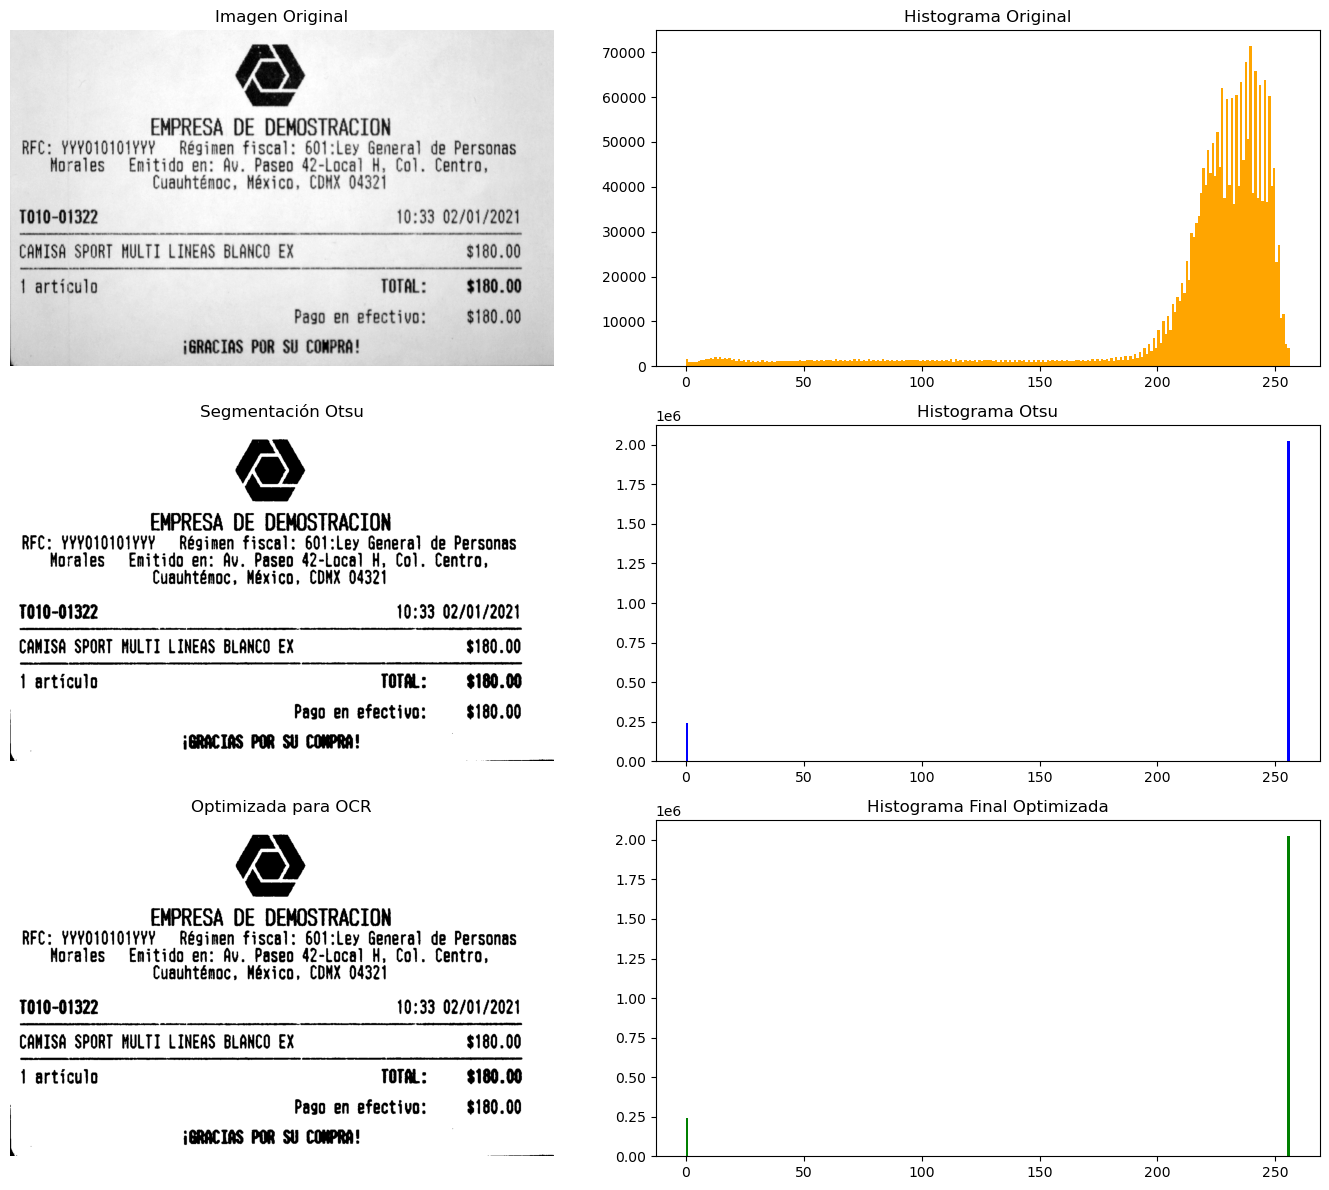

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Cargar imagen en escala de grises para simplificar el proceso.
img = cv2.imread('assets/ticket.jpg', cv2.IMREAD_GRAYSCALE)

# Aplicar filtro gaussiano para reducir ruido
img_filtrada = cv2.GaussianBlur(img, (3,3), 0)

# Aplicar CLAHE para corregir contraste
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img_filtrada)

# Aplicar Otsu, en este caso utilizaremos umbralización binaria + método otsu para el cálculo automático del úmbral óptimp.
_, img_otsu = cv2.threshold(img_clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Postprocesado morfológico, para prevenir caracteres segmentados o iregulares.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
img_final = cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, kernel)

# Visualización de imágenes y sus histogramas
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# Imagen original
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Imagen Original')
axs[0, 0].axis('off')
axs[0, 1].hist(img.ravel(), bins=256, range=(0, 256), color='orange')
axs[0, 1].set_title('Histograma Original')

# Imagen segmentada por Otsu
axs[1, 0].imshow(img_otsu, cmap='gray')
axs[1, 0].set_title('Segmentación Otsu')
axs[1, 0].axis('off')
axs[1, 1].hist(img_otsu.ravel(), bins=256, range=(0, 256), color='blue')
axs[1, 1].set_title('Histograma Otsu')

# Imagen final optimizada
axs[2, 0].imshow(img_final, cmap='gray')
axs[2, 0].set_title('Optimizada para OCR')
axs[2, 0].axis('off')
axs[2, 1].hist(img_final.ravel(), bins=256, range=(0, 256), color='green')
axs[2, 1].set_title('Histograma Final Optimizada')

plt.tight_layout()

#### Visualización y análisis

**Histograma de imágen Original**
En el **histograma** muestra una distribución de intensidades amplia, mayormente hacia los tonos claros, lo que es común en imágenes de tickets con texto negro sobre fondo claro.

**Histograma de imágen con segmentador Otsu**
En este **histograma** podemos ver una clara separación binaria: entre valores cercanos a 0 (negro) y 255 (blanco).

**Histograma de la imágen optimizada**
En este **histograma** podemos el resultado similar al segmentador otsu, solo que con algunas mejoras al aplicar los filtros.

-------

# MSER (Maximally Stable Extremal Regions)

Es un algoritmo para detectar regiones estables en una imagen basada en variaciones de intensidad. Las *"regiones extremales"* son áreas conectadas cuyos píxeles tienen intensidades consistentemente más claras o más oscuras que sus bordes. Se llaman *"máximamente estables"* porque su forma y tamaño cambian muy poco al variar un umbral de intensidad.

### ¿Cómo funciona?

- **Explora múltiples umbrales**: Se convierte la imagen en una serie de imágenes binarias aplicando distintos umbrales de intensidad.

- **Detecta regiones conectadas**: En cada imagen binaria se detectan regiones conectadas (blobs).

- **Evalúa estabilidad**: Se mide cuánto cambia el área de una región entre umbrales consecutivos.

- **Selecciona regiones estables**: Aquellas que cambian muy poco entre varios umbrales se consideran MSERs.

- 

### Características

- **Invariante a escala y rotación**: Detecta las mismas regiones incluso si la imagen se escala o rota.

- **Robusto a cambios de iluminación.**

- **No requiere entrenamiento**: Es un método basado en umbrales y análisis de conectividad.


### Aplicaciones Comunes

- **Reconocimiento de texto**: Muy útil para detectar caracteres en imágenes naturales (OCR).

- **Emparejamiento de imágenes**: Se usa como detector de características junto con descriptores como SIFT o SURF.

- **Visión por computador en tiempo real**: Debido a su eficiencia y precisión.

### Ejemplo: 

Supongamos que necesitamos automatizar la captura de texto en etiqetas de paquetes, los cuales van pasando por una banda.
Para este ejemplo, utilizaremos el reconocimiento de texto.

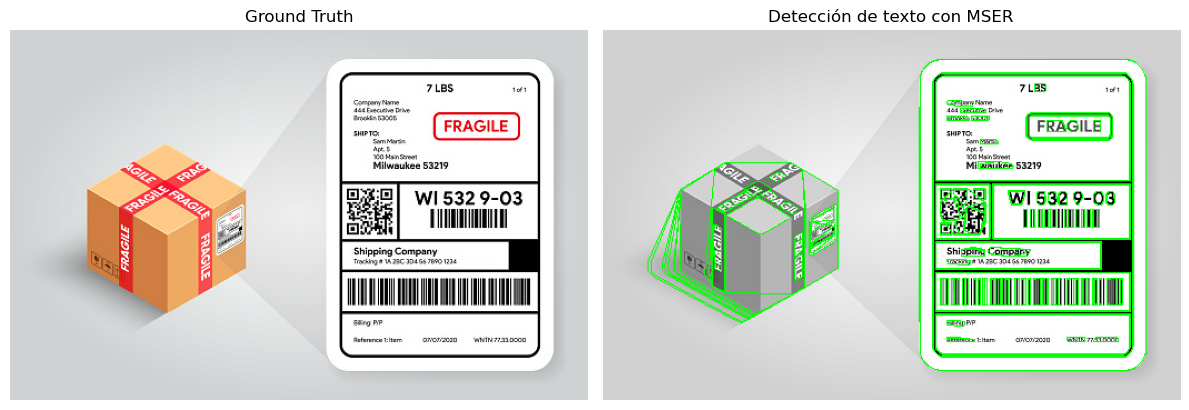

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Se carga una imagen para convertirla a escala de grises para que el reconocimiento de caracteres sea más preciso
imagen1 = cv2.imread('assets/label1.jpg', cv2.IMREAD_GRAYSCALE)

# Aquí se crea el MSER, la función toma de la librería CV2
mser = cv2.MSER_create()

# Detecta las regiones de la imagen precargada
regiones, _ = mser.detectRegions(imagen1)

# Ahora la imagen se pasa a color para comenzar a dibujar
imagen_color = cv2.cvtColor(imagen1, cv2.COLOR_GRAY2BGR)

# Aquí se comienzan a dibujar los contornos de las regiones detectadas
for region in regiones:
    contorno = cv2.convexHull(region.reshape(-1, 1, 2))
    cv2.polylines(imagen_color, [contorno], True, (0, 255, 0), 1)

# Ahora solo se pasa de formato BGR a RGB para la matplotlib
imagen_rgb = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)


GROUND_TRUTH = plt.imread('assets/label1.jpg')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(GROUND_TRUTH)
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 2, 2)

plt.imshow(imagen_rgb)
plt.title("Detección de texto con MSER")
plt.axis("off")
plt.tight_layout()
plt.show()



------

# Watershed

El término watershed (o algoritmo de segmentación por líneas de cresta), proviene del concepto geográfico de _"línea divisoria de aguas"_. Este método es una técnica utilizada en procesamiento de imágenes y visión por computadora para segmentar una imagen, es decir, para dividirla en regiones significativas (como objetos individuales).

### ¿Cómo Funciona?

- **Interpretación de la imagen como topografía**: cada valor de píxel representa una altitud.

- **Identificación de mínimos locales**: se detectan los puntos más bajos en la imagen, que servirán como “semillas” o fuentes de agua.

- **Crecimiento de regiones**: como si llenaras los valles con agua, se va "inundando" la imagen desde estas semillas.

- **Construcción de barreras**: cuando el agua de diferentes regiones está a punto de unirse, se construyen "diques" para evitar la mezcla. Estos diques son las líneas de segmentación.


### Características

Aunque no necesita entrenamiento, sí puede mejorarse con preprocesamiento, como:

- Filtrado (Gaussian blur, etc.) para reducir ruido.
- Transformada de distancia para marcar centros de objetos.
- Detección de bordes (Canny, Sobel) para definir contornos.

### Aplicaciones Comunes:

- Segmentar objetos conectados entre sí, por ejemplo, en imágenes de células, granos, frutas, etc.

- Separar regiones de interés en imágenes donde otros métodos fallan.

- Detección de bordes y formas con precisión.


### Ejemplo1:

Ahora bien, supongamos que una vez que se han identificado los textos de las etiquetas de las cajas, queremos contar dichas cajas al terminar su recorrido en la banda.

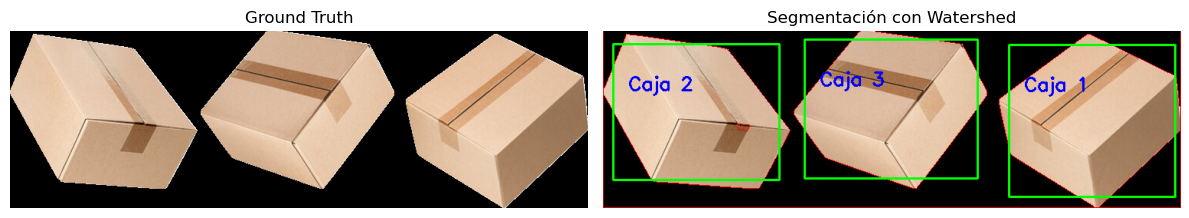

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carga de imagen (para este ejemplodebe tener fondo negro y figuras blancas)
imagen = cv2.imread('assets/boxes.png')
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Binarización
_, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Sustracción de Ruido
kernel = np.ones((3, 3), np.uint8)
abierta = cv2.morphologyEx(binaria, cv2.MORPH_OPEN, kernel, iterations=2)

# Fondo estable
fondo_seguro = cv2.dilate(abierta, kernel, iterations=3)

# Primer plano: centro de las figuras
dist_transform = cv2.distanceTransform(abierta, cv2.DIST_L2, 5)
_, primer_plano = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
primer_plano = np.uint8(primer_plano)

# Región desconocida
desconocido = cv2.subtract(fondo_seguro, primer_plano)

# Etiquetado de cada componente detectado
_, marcadores = cv2.connectedComponents(primer_plano)

marcadores = marcadores + 1
marcadores[desconocido == 255] = 0

# Ahora se puede aplicar Watershed
imagen_color = imagen.copy()
cv2.watershed(imagen_color, marcadores)

imagen_color[marcadores == -1] = [0, 0, 255]

# Dibujo de contornos y número de cada figura
contornos, _ = cv2.findContours(primer_plano, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contornos):
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(imagen_color, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(imagen_color, f"Caja {i+1}", (x+20, y+60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB))
plt.title("Segmentación con Watershed")
plt.axis("off")

plt.tight_layout()
plt.show()


### Ejemplo 2:

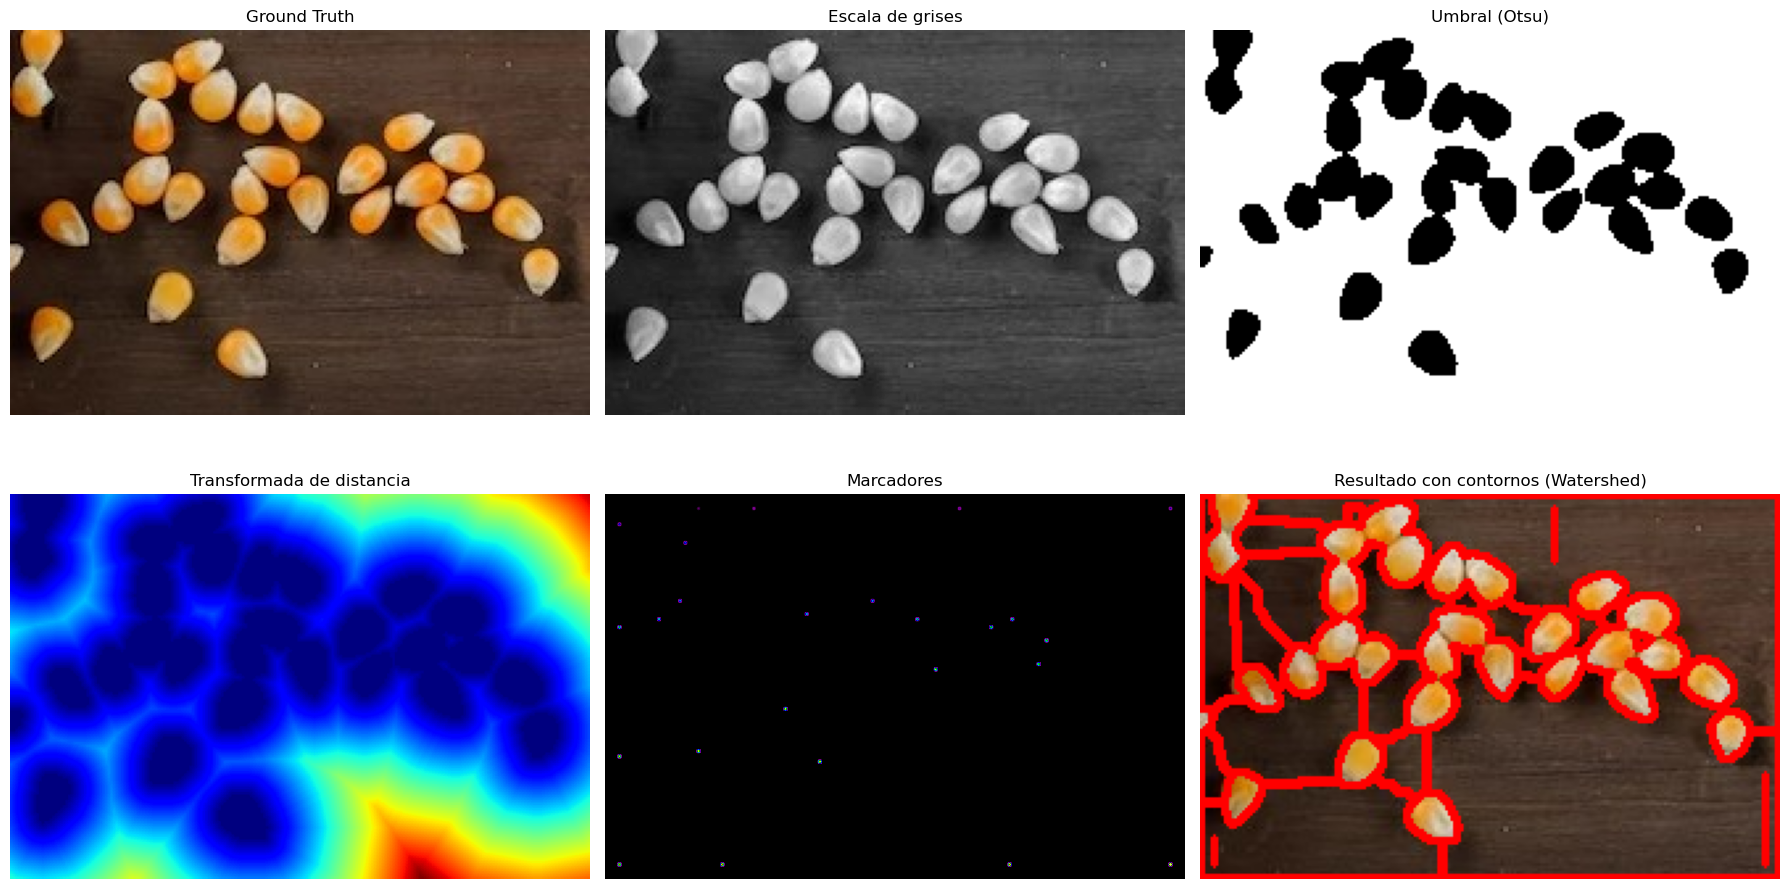

In [5]:
#Cargamos imagen original, y convertimos a escala de grises
imagen = cv2.imread('assets/maiz.jpg')
image_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)


# Filtro de suavizado
# Aplicamos un filtro Gaussiano para reducir el ruido. Esto evita que el algoritmo de umbral o segmentación detecte detalles irrelevantes
blurred = cv2.GaussianBlur(gray, (5, 5), 0)


# Umbral usando Otsu debemos de estar pendientes ya que si tuvieramos el fondo claro o resaltado tendriamos que usar cv2.THRESH_BINARY_INV
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Transformada de distancia
#Esta operación calcula, para cada píxel blanco (Maíz), la distancia al píxel negro más cercano (borde)

distance = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

# Encontrar picos locales
# Estos puntos serán los semilleros o marcadores para el algoritmo Watershed. Es decir, le decimos “aquí hay un objeto, empieza a crecer desde aquí”.

coordinates = peak_local_max(distance, min_distance=5, labels=thresh)
local_max = np.zeros_like(distance, dtype=bool)
local_max[tuple(coordinates.T)] = True

# Etiquetar marcadores
# Asignamos una etiqueta distinta a cada pico detectado, cada numero representará una región diferente.

markers, _ = ndi.label(local_max)

# Aplicar metodo Watershed

labels = watershed(-distance, markers, mask=thresh)


# Dibujar contornos sobre la imagen original
# Para cada región segmentea se crea una máscara, se detectan sus contornos y la dibujaremos sobre la imágen original.

image_contours = image_rgb.copy()
for label in np.unique(labels):
    if label == 0:
        continue
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image_contours, contours, -1, (255, 0, 0), 2)  # Azul

# Mostrar resultados
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

axes[0].imshow(image_rgb)
axes[0].set_title("Ground Truth")
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title("Escala de grises")
axes[1].axis('off')

axes[2].imshow(thresh, cmap='gray')
axes[2].set_title("Umbral (Otsu)")
axes[2].axis('off')

axes[3].imshow(distance, cmap='jet')
axes[3].set_title("Transformada de distancia")
axes[3].axis('off')

axes[4].imshow(markers, cmap='nipy_spectral')
axes[4].set_title("Marcadores")
axes[4].axis('off')

axes[5].imshow(image_contours)
axes[5].set_title("Resultado con contornos (Watershed)")
axes[5].axis('off')

plt.tight_layout()
plt.show()

------

# Deeplab

Es una arquitectura de red neuronal convolucional especializada en segmentación semántica. Existen varias versiones, cada una mejorando a la anterior:

- **DeepLabv1**: Introdujo convoluciones atrous o convoluciones dilatadas, que permiten aumentar el campo de visión de la red sin perder resolución espacial.

- **DeepLabv2**: Mejoró con el uso de dilataciones múltiples (ASPP - Atrous Spatial Pyramid Pooling) para captar información a diferentes escalas.

- **DeepLabv3**: Refinó el ASPP y mejoró la arquitectura general.

- **DeepLabv3+**: Combinó ASPP con un decodificador para refinar los bordes y mejorar la segmentación.


## Aplicaciones comunes

- **Conducción autónoma**: Detección de carreteras, peatones, señales de tráfico, etc.

- **Medicina**: Segmentación de órganos, tejidos o tumores en imágenes médicas.

- **Agricultura de precisión**: Detección de cultivos, plagas o áreas afectadas.

- **Análisis satelital**: Clasificación del uso del suelo o detección de cambios.

- **Edición de imágenes**: Recorte automático de objetos o sustitución de fondos.



### Ejemplo:

Para este ejemplo se toma un modelo de TensorFlow así como el dataset

In [37]:
from google.colab import files
uploaded = files.upload()

### Se importan las librerias necesarias provenientes de TensorFlow (_además de las comunmente usadas en Opencv_)

In [38]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# %tensorflow_version 1.x
import tensorflow as tf
# Se importa TensorFlow mayor a 1.x para la compatibilidad de módulos
import tensorflow.compat.v1 as tf_compat_v1

# Se desabilitan comportamientos de funciones de TensorFlow 2.x
tf_compat_v1.disable_v2_behavior()

### Se importan métodos útiles para:


*   Cargar la última versión preentrenada del modelo de **DeepLab**
*   Cargar el colormap del dataset PASCAL VOC
*   Agregar colores a varias etiquetas, como 'Pink' para las personas o 'green' para objetos
*   Visualizar una imagen y el overlay de colores en varias regiones



In [46]:
class DeepLabModel(object):

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    self.graph = tf_compat_v1.Graph() # Use tf.compat.v1.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        # Use tf.compat.v1.GraphDef.FromString
        graph_def = tf_compat_v1.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('No se encuentra inferencia de grafo en archivo tar.')

    with self.graph.as_default():
      tf_compat_v1.import_graph_def(graph_def, name='') # Use tf.compat.v1.import_graph_def

    self.sess = tf_compat_v1.Session(graph=self.graph) # Use tf.compat.v1.Session()


  def run(self, image):
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    # Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
    resized_image = image.convert('RGB').resize(target_size, Image.Resampling.LANCZOS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):

  if label.ndim != 2:
    raise ValueError('Se espera 2-D etiqueta de entrada')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('Valor de etiqueta muy largo.')

  return colormap[label]


def vis_segmentation(image, seg_map):

  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('Ground Truth')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('Mapa de segmentación')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('overlay de segmentación')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Se selecciona el modelo Preentrenado

Este modelo de **DeepLab** ahora ha sido entrenado usando varias redes troncales _(backbone networks)_.
En la lista de la derecha DeepLab nos muestra un conjunto de varias para seleccionar alguna de ellas. Para este ejemplo se usará **xception_coco_voctrainaug**

In [50]:
MODEL_NAME = 'xception_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
# Replace tf.gfile.MakeDirs with tf.io.gfile.makedirs
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('Descargando Modelo, puede tardar un poco...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('Descarga Completa Cargando modelo de DeepLab...')

MODEL = DeepLabModel(download_path)
print('Modelo cargado con éxito!')

Descargando Modelo, puede tardar un poco...
Descarga Completa Cargando modelo de DeepLab...
Modelo cargado con éxito!


### Ahora solo se aplica en 3 diferentes imagenes obtenidas de un dataset de Tensoflow


Cargando imagen de: https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image3.jpg?raw=true...


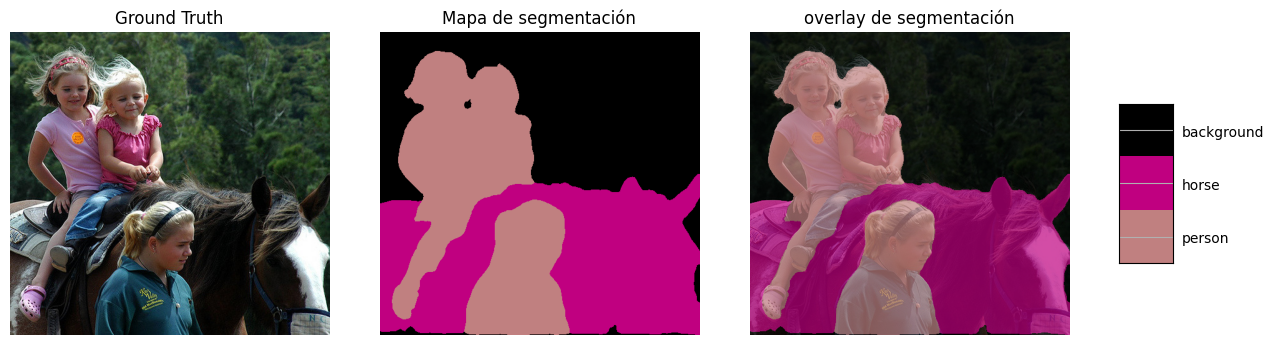

In [53]:

SAMPLE_IMAGE = 'image3'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = '' # @param {"type":"string","placeholder":"Ingresa texto"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('No se puede obtener una imagen, verifica la url: ' + url)
    return

  print('Cargando imagen de: %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

---

# Comparación de Segmentadores

|                          | **MSER**                                                                     | **Watershed**     | **OTSU**                                                                                   | **DeepLab**                                                         |
|------------------------------|------------------------------------------------------------------------------|-------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------------|
| **Implementación**           | Fácil                                                                        | Media             | Media                                                                                      | Compleja                                                            |
| **¿requiere entrenamiento?** | no                                                                           | no                | no                                                                                         | Si,(en caso de no usar algún modelo de Google)                      |
| **Desventajas**              | sensible al ruido, no segmenta formas complejas, costoso en imágenes grandes | sensible al ruido | Depende mucho del histograma, No es útil con múltiples objetos o clases, sensible al ruido | Costoso, arquitectura compleja, resultados ruidosos en bordes finos |



-----

# Conclusiones

Se pudo observar que los diferentes tipos de segmentadores tienen diferentes aplicaciones, pero además, la combinación de usos que se puede llevar a cabo cuando es necesario.

Sin embargo, también pudimos ver, que los modelos de _Deep learning_ tienen muchas ventajas, pero también muchos de ellos, costes computacionales elevados, esto quiere decir que podemos usarlos para muestras o datasets pequeños, o bien modelos más complejos para usos científicos más grandes, como por ejemplo en la agricultura, en manufacturas, etc.

También, un dato muy interesante es que gracias a este trabajo, nos dimos cuenta de como cada una de las implementaciones nos fue ayudando a desarrollar un análisis más claro de cada módelo conforme íbamos seleccionandolos con cada vez más mayor complejidad.

